# 임베딩을 사용한 비지도 클러스터링 및 명명된 클러스터 (그리고 기타 재미있는 작업)

이 노트북에서는 [Top 10000 Popular Movies Dataset](https://www.kaggle.com/datasets/db55ac3dfd0098a0cf96dd542807f9253a16587ff233e06baef372bccfd09942)의 하위 집합을 사용하여 영화 설명에 대한 임베딩을 계산한 후 k-means를 적용하여 유사한 클러스터를 찾습니다. 클러스터를 얻은 후에는 프롬프트를 사용하여 각 클러스터의 주제를 추출합니다.

In [2]:
!pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 55.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 90.4 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)


In [18]:
import os
import tiktoken
import openai
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from openai import AzureOpenAI

from tenacity import retry, wait_random_exponential, stop_after_attempt

# Load environment variables
load_dotenv(override=True)

client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_KEY"),  
  api_version="2024-02-15-preview"
)

def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# Define embedding model and encoding
EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL_NAME")
model = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")

encoding = tiktoken.get_encoding('cl100k_base')

`movies.csv`를 로드합니다:

In [4]:
df = pd.read_csv('data/movies.csv')
print(df.shape)
df.head(3)

(500, 12)


,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.


다음으로, 새로운 열을 생성하고 각 임베딩에 필요한 토큰 수를 계산해 봅시다. 이를 통해 전체 데이터셋에 대해 임베딩을 생성하는 데 드는 비용을 추정할 수 있습니다.

In [6]:
# add a new column to the dataframe where you put the token count of the review
df = df.assign(token_count=df['overview'].apply(lambda x: len(encoding.encode(x))))

# print the first 5 rows of the dataframe, then also the total number of tokens
total_tokens = df['token_count'].sum()

cost_for_embeddings = total_tokens / 1000 * 0.0001
print(f"Test would cost ${cost_for_embeddings} for embeddings")

Test would cost $0.0029391 for embeddings


임베딩 메서드를 정의해 봅시다. Azure OpenAI 서비스의 TPS 제한에 도달할 경우를 대비하여 자동 재시도 메커니즘을 제공하는 tenacity의 사용에 주목하세요.

In [ ]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
def get_embedding(text) -> list[float]:
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=EMBEDDING_MODEL).data[0].embedding
 

임베딩을 생성해 봅시다:

In [12]:
df = df.assign(embedding=df['overview'].apply(lambda x: get_embedding(x)))
df.head(6)

,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.016805129125714302, -0.01393564697355032, ..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.006607969291508198, -0.02256608009338379, ..."
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[-0.011366992257535458, -0.028693873435258865,..."
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[-0.0013119977666065097, -0.03693384677171707,..."
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.006472007371485233, -0.020479165017604828,..."
5,505262.0,ja,僕のヒーローアカデミア THE MOVIE ～2人の英雄～,220.805,2018-08-03,8.0,677.0,"['Animation', 'Action', 'Adventure', 'Fantasy']",All Might and Deku accept an invitation to go ...,3.147883e+07,96.0,Who is your hero?,98,"[0.005911096930503845, -0.031393833458423615, ..."


다음으로, KMeans를 사용하여 임베딩에 클러스터를 생성합니다. 이 경우, 5개의 클러스터를 선택하지만, 이것이 정확하지 않을 수도 있습니다.

In [16]:
# train k-means on df embeddings
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(df['embedding'].to_list())
df = df.assign(cluster=kmeans.labels_)
df.head(10)

/Users/andy/works/ai/msft-ai-workshop/.venv/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding,cluster
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.016805129125714302, -0.01393564697355032, ...",0
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.006607969291508198, -0.02256608009338379, ...",4
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[-0.011366992257535458, -0.028693873435258865,...",4
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[-0.0013119977666065097, -0.03693384677171707,...",2
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.006472007371485233, -0.020479165017604828,...",4
5,505262.0,ja,僕のヒーローアカデミア THE MOVIE ～2人の英雄～,220.805,2018-08-03,8.0,677.0,"['Animation', 'Action', 'Adventure', 'Fantasy']",All Might and Deku accept an invitation to go ...,3.147883e+07,96.0,Who is your hero?,98,"[0.005911096930503845, -0.031393833458423615, ...",0
6,3512.0,en,Under Siege 2: Dark Territory,19.217,1995-07-13,5.7,608.0,"['Action', 'Thriller']",A passenger train has been hijacked by an elec...,1.043241e+08,100.0,Last time he rocked the boat. This time the sk...,48,"[-0.01933574303984642, 0.002167288213968277, -...",4
7,10649.0,en,The Enforcer,14.938,1976-12-20,6.9,599.0,"['Action', 'Crime', 'Thriller']","Dirty Harry Callahan returns again, this time ...",4.623600e+07,96.0,The dirtiest Harry of them all.,31,"[-0.025958223268389702, -0.040821827948093414,...",4
8,103332.0,en,Ruby Sparks,14.750,2012-07-25,7.1,1249.0,"['Comedy', 'Romance', 'Fantasy', 'Drama']",Calvin is a young novelist who achieved phenom...,9.128263e+06,104.0,She's Out Of His Mind,82,"[-0.002566759940236807, -0.03235512226819992, ...",1
9,180296.0,en,They Came Together,9.290,2014-06-27,5.6,306.0,['Comedy'],A small business owner is about to lose her sh...,0.000000e+00,83.0,He came...She came...They both came,16,"[-0.01819261908531189, -0.02455485239624977, 0...",1


이제 각 행에 클러스터가 있으므로 t-SNE를 사용하여 임베딩을 2차원 공간으로 투영하고 클러스터를 시각화해 봅시다.

(500, 1536)


/var/folders/pr/hngks2mn74d25jycvx6rxl400000gn/T/ipykernel_79251/2572688562.py:20: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
/Users/andy/works/ai/msft-ai-workshop/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/pr/hngks2mn74d25jycvx6rxl400000gn/T/ipykernel_79251/2572688562.py:21: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


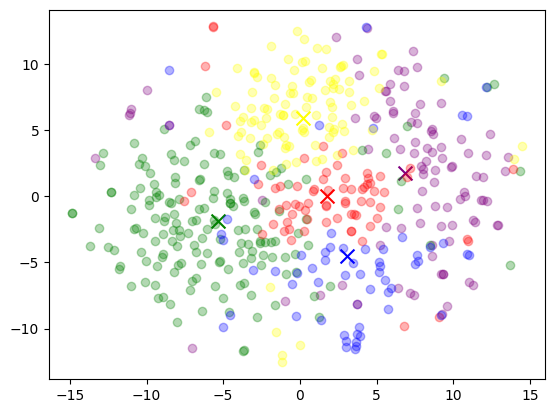

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=50, random_state=42, init="random", learning_rate=200
)

matrix = np.vstack(df.embedding.values)
print(matrix.shape)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow", 'black', 'orange', 'brown', 'pink', 'grey']):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

음, 예상했던 대로 그다지 좋아 보이지는 않습니다. 우리는 모든 종류의 영화를 가지고 있으며, 단 5개의 클러스터만으로는 이상적이지 않을 수 있습니다. 하지만 자세히 보면 클러스터를 닮은 대략적인 모양을 만들 수 있습니다. 또한 영화는 두 개 이상의 카테고리에 속할 수 있으므로 어느 정도 말이 됩니다.

마지막으로, 각 클러스터에서 몇 가지 예를 가져와 OpenAI에 보내고 공통 주제를 추출해 봅시다:

In [20]:
# take 10 movies from each cluster and write a prompt that asks what these have in common
# ideally you would use more movies than 10, but this is just a demo


for i in range(n_clusters):
    reviews = df[df['cluster'] == i]['overview'].sample(10)
    reviews = "\n".join(reviews.values.tolist())
    
    prompt = f"다음은 10개의 영화 설명입니다: \n{reviews}이들의 공통점을 세 단어로 적어 보세요."
    print(prompt)
    response = client.chat.completions.create(
        model=model, 
        messages = [
                        {"role":"system", "content":"You are a helpful assistant."},
                        {"role":"user","content":prompt}
                    ])
    topic_content = response.choices[0].message.content                

    print(f"Cluster {i} topics: {topic_content}")
    movies = df[df['cluster'] == i]['original_title'].sample(25)
    print(f"Movies from cluster {i}: {', '.join(movies.values.tolist())}")
    print("================")    

다음은 10개의 영화 설명입니다: 
The Swedish Björn Borg and the American John McEnroe, the best tennis players in the world, maintain a legendary duel during the 1980 Wimbledon tournament.
As two evil sisters prepare to conquer the land, two renegades—Eric the Huntsman, who aided Snow White in defeating Ravenna in Snowwhite and the Huntsman, and his forbidden lover, Sara—set out to stop them.
The magical kingdom of Lucis is home to the world’s last remaining Crystal, and the menacing empire of Niflheim is determined to steal it. King Regis of Lucis commands an elite force of soldiers called the Kingsglaive. Wielding their king’s magic, they fight to protect Lucis. As the overwhelming military might of the empire bears down, King Regis is faced with an impossible ultimatum – to marry his son, Prince Noctis to Princess Lunafreya of Tenebrae, captive of Niflheim, and surrender his lands to Niflheim rule.  Although the king concedes, it becomes clear that the empire will stop at nothing to achieve thei

그렇게 나쁘지 않아 보입니다. 하지만 다시 말하지만, 각 클래스에 대해 10개의 샘플만 사용하는 것은 클러스터 수가 적다는 점을 고려할 때 충분하지 않을 수 있습니다. 어쨌든 영화 제목을 보면 일부 주제가 실제로 꽤 괜찮게 보입니다.

# 임베딩을 사용하여 간단한 추천 시스템 구축

또 다른 작업으로는 임베딩을 사용하여 매우 간단한 추천 시스템을 구축하는 것입니다. 한 번 시도해 봅시다:

In [21]:
# Let's pick a movie that exists in df, keeping in mind we only have 500 movies in it!
movie = "Frozen"

# get embedding for movie
e = df[df['original_title'] == movie]['embedding'].values[0]

# get cosine similarity between movie and all other movies and sort ascending
similarities = df['embedding'].apply(lambda x: cosine_similarity(x, e))

# get most similar movies
movies = df.assign(similarity=similarities).sort_values(by='similarity', ascending=False)[['original_title', 'similarity', 'overview']]
movies[0:6]

,original_title,similarity,overview
480,Frozen,1.000000,Young princess Anna of Arendelle dreams about ...
361,The Huntsman: Winter's War,0.861227,As two evil sisters prepare to conquer the lan...
468,The Swan Princess,0.856962,The beautiful princess Odette is transformed i...
161,Beauty and the Beast,0.848221,A live-action adaptation of Disney's version o...
173,Cinderella,0.841805,"When her father unexpectedly passes away, youn..."
286,Wonder Woman,0.841401,An Amazon princess comes to the world of Man i...


마지막 것을 제외하고는 실제로 꽤 괜찮아 보입니다... 아마도 추천에 영화 카테고리와 연령 등급을 추가했다면 더 유용했을 것입니다... :)